## 🚦 Introduction - Traffic Light Detection using Pytorch | FasterRCNN

![Traffic-Light](https://media.giphy.com/media/l1AsA1IZNWFyo6xlm/giphy.gif)

---

We will be using Object-Detection techniques to **Detect Traffic Lights**. For this we will use **Transfer-Learning** and the base architecture will be **FasterRCNN**. 

### 🤔 What is FasterRCNN?

![Faster-RCNN](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Screenshot-from-2018-10-09-14-15-36.png)

Faster RCNN is the modified version of **Fast RCNN**. The major difference between them is that **Fast RCNN uses selective search** for generating Regions of Interest, while **Faster RCNN uses “Region Proposal Network”**, aka RPN. RPN takes image feature maps as an input and generates a set of **object proposals**, each with an **objectness score** as output.  

The  below steps are typically followed in a Faster RCNN approach:
1. We take an image as input and pass it to the ConvNet which returns the feature map for that image.
2. Region proposal network is applied on these feature maps. This returns the object proposals along with their objectness score.
3. A RoI pooling layer is applied on these proposals to bring down all the proposals to the same size.
4. Finally, the proposals are passed to a fully connected layer which has a softmax layer and a linear regression layer at its top, to classify and output the bounding boxes for objects.

*For **Region Proposal Network (RPN)** & more on **Object Detection** look here* - [🚀](https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/)

### 📦 Data Set:
**LISA Traffic Light Dataset** - [🚀](https://www.kaggle.com/mbornoe/lisa-traffic-light-dataset)  
It has more than **44 minutes** of **annotated traffic light** data.

## 1. Importing Necessary Libraries

In [1]:
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler


# Seed Everything for Reproducibility
SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

## 2. Load Data

In [2]:
DATA_PATH = '../input/lisa-traffic-light-dataset'
os.listdir(DATA_PATH)

['sample-nightClip1',
 '.DS_Store',
 'daySequence2',
 'nightSequence1',
 'nightTrain',
 'Annotations',
 'daySequence1',
 'sample-dayClip6',
 'dayTrain',
 'nightSequence2']

In [3]:
DAY_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/'

### Merge all different Annotation Files into a single file

**"isNight"** feature will be used to split the data so that there will be balance between **Day & Night Clips** in **Train & Test sets**

In [4]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0
    
train_night = []
for clipName in tqdm(sorted(os.listdir(NIGHT_TRAIN_PATH))):
    if 'nightClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(NIGHT_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_night.append(df)

train_night_df = pd.concat(train_night,axis=0)
train_night_df['isNight'] = 1

df = pd.concat([train_day_df,train_night_df],axis=0)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 95.77it/s]


In [5]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number,isNight
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,0
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,0


## 3. Data Preprocessing

In [6]:
# Duplicate Columns
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [7]:
# Droppin duplicate columns & "Origin file" as we don't need it
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [8]:
# Here Filename (Location of Image) is different -> Change it to appropriate name
# Ex. dayTraining/dayClip1--00000.jpg -> dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg

def changeFilename(x):
    filename = x.Filename
    isNight = x.isNight
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    if isNight:
        return os.path.join(DATA_PATH,f'nightTrain/nightTrain/{clipName}/frames/{splitted[-1]}')
    else:
        return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [9]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [10]:
# We will change annotations to only -> stop (RED), go (GREEN) & warning (YELLOW)
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2])

In [11]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number,isNight
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0


In [12]:
# Changing Column Names
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame','isNight']

In [13]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0


## 4. Exploratory Data Analysis

In [14]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  18013 / 51826


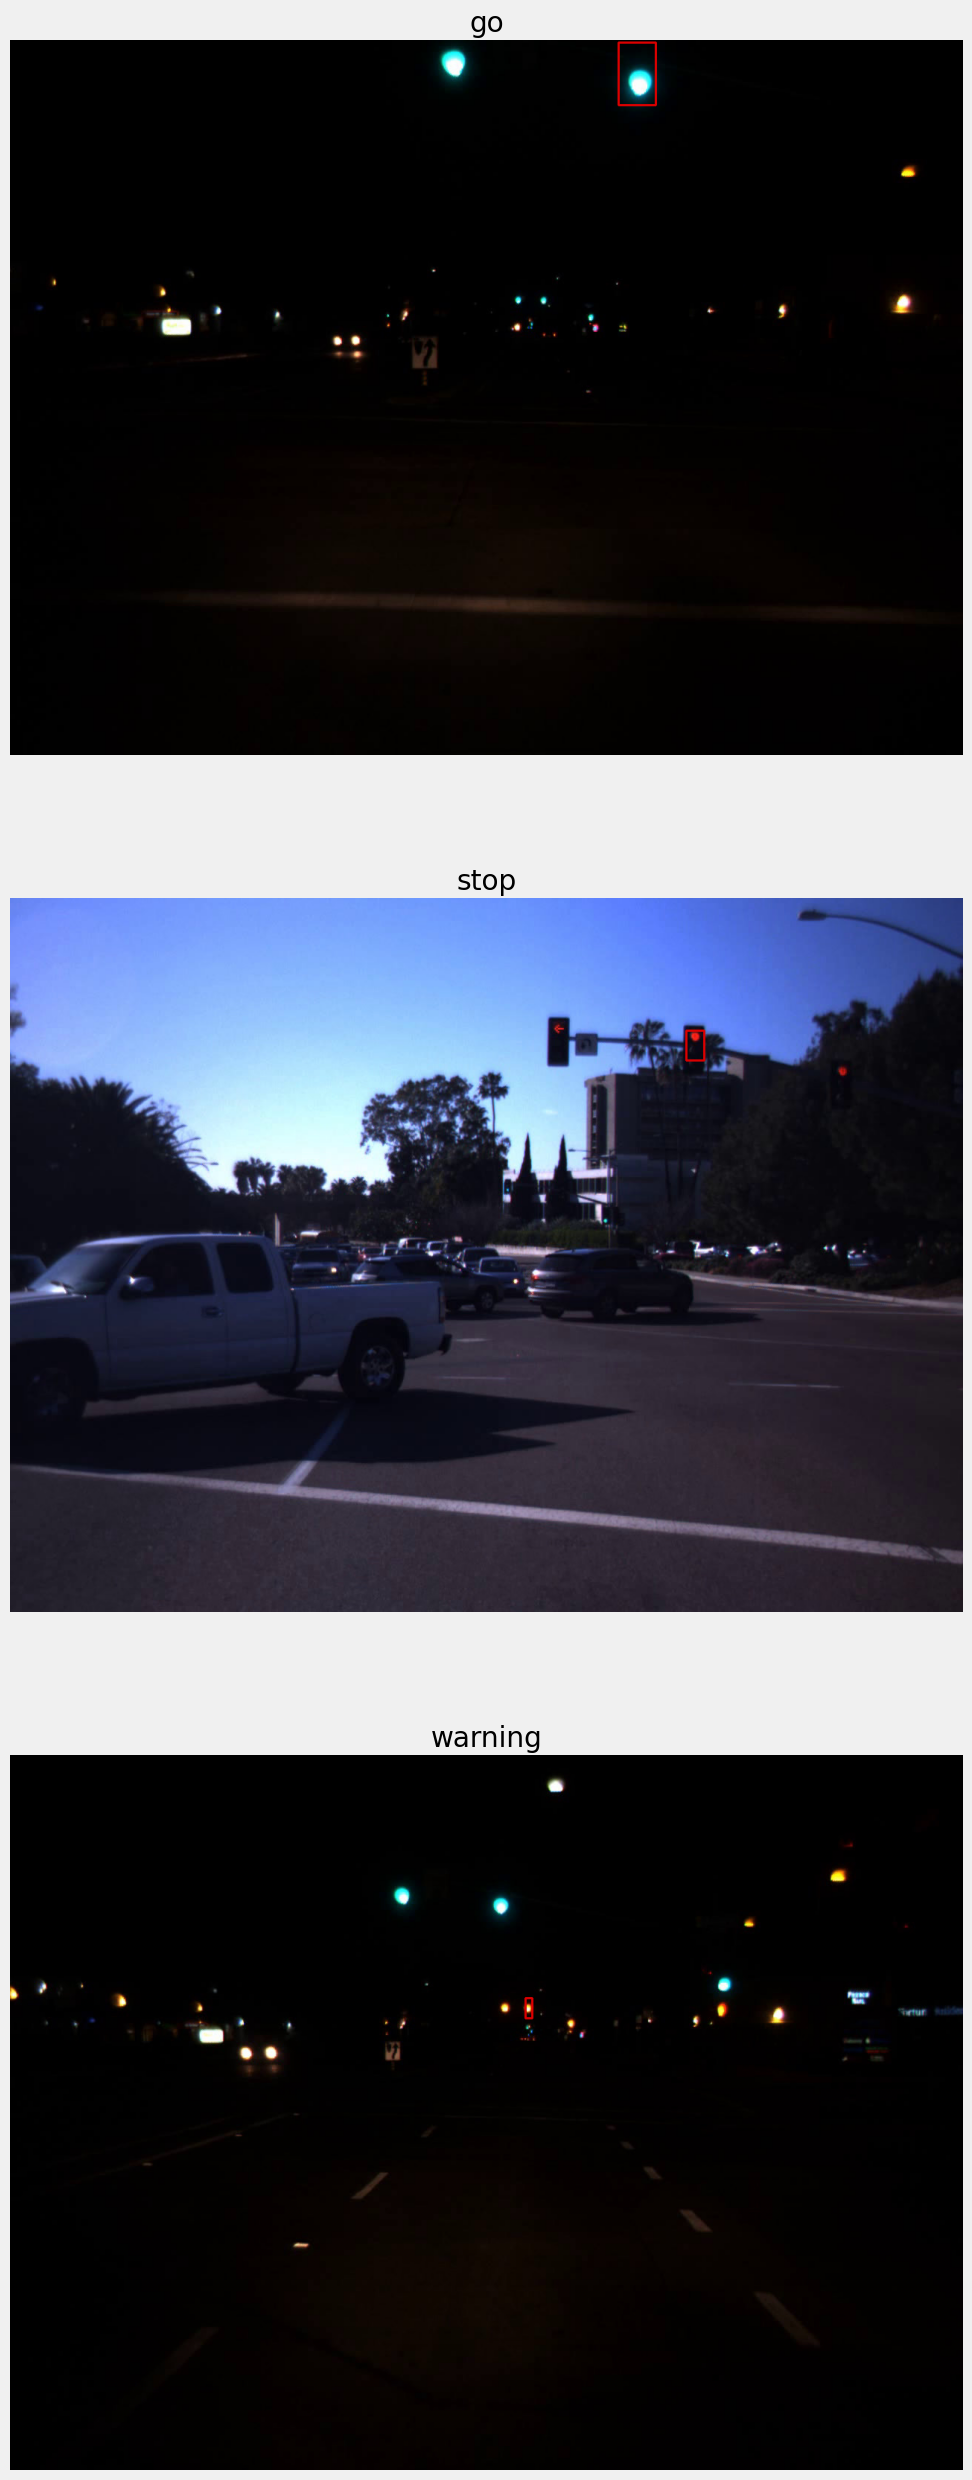

In [15]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

## 5. Validation Scheme

As we have data from multiple clips, we will have to ensure that all the images from a same clip would either be in the **train set** or in **test set**. This will ensure that, there will not be any **overlapping** between the train & the test data.

In [16]:
df['image_id'].unique()

array(['../input/lisa-traffic-light-dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg',
       '../input/lisa-traffic-light-dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg',
       '../input/lisa-traffic-light-dataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg',
       ...,
       '../input/lisa-traffic-light-dataset/nightTrain/nightTrain/nightClip5/frames/nightClip5--01450.jpg',
       '../input/lisa-traffic-light-dataset/nightTrain/nightTrain/nightClip5/frames/nightClip5--01451.jpg',
       '../input/lisa-traffic-light-dataset/nightTrain/nightTrain/nightClip5/frames/nightClip5--01452.jpg'],
      dtype=object)

In [17]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[5])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9', 'nightClip1', 'nightClip2',
       'nightClip3', 'nightClip4', 'nightClip5'], dtype=object)

In [18]:
len(df['clipNames'].unique())

18

### Train & Test Set split

In [19]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    testNightClipNames = list(np.random.choice(nightClips,int(len(nightClips)*p)))
    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testNightClipNames + testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [20]:
train_df, test_df = split(df)

In [21]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0,dayClip1
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0,dayClip1
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0,dayClip1
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0,dayClip1
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0,dayClip1


In [22]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,271,379,283,399,0,0,dayClip12
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,610,294,625,314,0,0,dayClip12
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,774,359,792,394,0,0,dayClip12
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,266,364,284,404,1,0,dayClip12
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,609,293,627,313,1,0,dayClip12


In [23]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (47084, 9)
Test shape:  (4742, 9)


### Train & Validation Split

We will do the similar thing that we did for the train-test-split above

In [24]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,333,710,358,0,0,dayClip1
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,846,391,858,411,0,0,dayClip1
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,337,710,357,1,0,dayClip1
3,../input/lisa-traffic-light-dataset/dayTrain/d...,1,847,390,859,410,1,0,dayClip1
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,698,331,710,356,2,0,dayClip1


In [25]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,isNight,clipNames
0,../input/lisa-traffic-light-dataset/dayTrain/d...,1,323,288,335,308,0,0,dayClip10
1,../input/lisa-traffic-light-dataset/dayTrain/d...,1,506,376,518,396,0,0,dayClip10
2,../input/lisa-traffic-light-dataset/dayTrain/d...,1,587,369,599,389,0,0,dayClip10
3,../input/lisa-traffic-light-dataset/dayTrain/d...,3,210,261,222,279,0,0,dayClip10
4,../input/lisa-traffic-light-dataset/dayTrain/d...,1,330,286,342,306,1,0,dayClip10


In [26]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (37128, 9)
Validation shape:  (9956, 9)


In [27]:
# train_df = train_df.sample(frac=0.1)
# print("Train shape: ",train_df.shape)

## 6. Utils

### Configuration

In [28]:
EPOCHS = 3
BATCH_SIZE = 16

### Device

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### Custom DataSet

In [30]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        # Area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

### Average Loss

In [31]:
# Average loss -> (Total-Loss / Total-Iterations)
class LossAverager:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [32]:
# Custom Batching with no collate function your batch data would look like:
# [(img_0, targets_0), (img_1, targets_1), ...]
# but with the collate function it would be more like
# [(img_0, img_1), (targets_0, targets_1), ...]

def collate_fn(batch):
    return tuple(zip(*batch))

### Albumentations

In [33]:
# Albumentations

# For Train Data
def getTrainTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Validation Data
def getValTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Test Data
def getTestTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### Data Loaders

In [34]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [38]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

### Checking DataPipeline

In [39]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].numpy().astype(np.int32)
image = images[0].permute(1,2,0).numpy()

In [51]:
targets[0]

{'boxes': tensor([[335.2000, 385.0667, 348.4000, 416.0000],
         [394.8000, 373.3333, 405.6000, 397.3333],
         [463.2000, 333.3333, 474.0000, 354.6667]]),
 'labels': tensor([3, 3, 3]),
 'image_id': tensor([1132]),
 'area': tensor([1914., 1215., 1080.]),
 'iscrowd': tensor([0, 0, 0])}

In [40]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


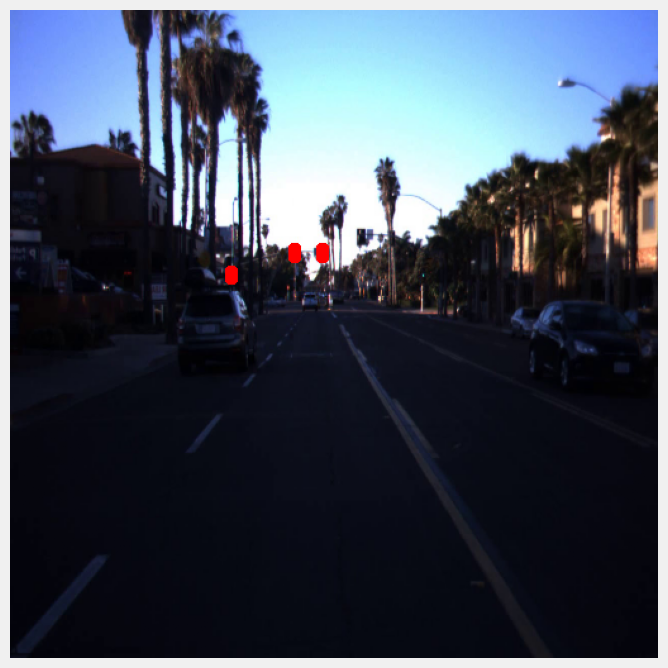

In [41]:
displayImage(image,boxes)

## 7. Model

In [42]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4  # 3 classes (Stop, Warning, Go) + Background

# Number of Input Features for the Classifier Head
INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

# New Head for Classification
model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/aniruddhamukherjee/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:19<00:00, 8.53MB/s] 


## 8. Training

In [ ]:
# model.to(device)

# params = [p for p in model.parameters() if p.requires_grad]
# # Optimizers
# optimizer = torch.optim.Adam(params)

# # LR Scheduler
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
# lossHist = LossAverager()
# valLossHist = LossAverager()

# for epoch in range(EPOCHS):
    
#     start_time = time()
#     model.train()
#     lossHist.reset()
    
#     for images, targets, image_ids in tqdm(trainDataLoader):
        
#         images = torch.stack(images).to(device)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         bs = images.shape[0]
        
#         loss_dict = model(images, targets)
        
#         totalLoss = sum(loss for loss in loss_dict.values())
#         lossValue = totalLoss.item()
        
#         lossHist.update(lossValue,bs)

#         optimizer.zero_grad()
#         totalLoss.backward()
#         optimizer.step()
    
#     # LR Update
#     if lr_scheduler is not None:
#         lr_scheduler.step(totalLoss)

#     print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
#     print(f"Epoch {epoch}/{EPOCHS}")
#     print(f"Train loss: {lossHist.avg}")
    
#     torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [44]:
model.load_state_dict(torch.load('../input/trafficlightdetectionfasterrcnnweights/fasterrcnn_resnet50_fpn.pth', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

## 9. Inference

In [67]:
model.eval()
images, targets, image_ids = next(iter(testDataLoader))
images, targets, image_ids = next(iter(testDataLoader))
# images, targets, image_ids = next(iter(testDataLoader))
images = torch.stack(images).to(device)

outputs = model(images)

In [68]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    # Non Max Supression
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [69]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    # Preprocessing
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
    
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)

    ax.set_axis_off()
    ax.imshow(image)
    print(labels)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1 1 1]


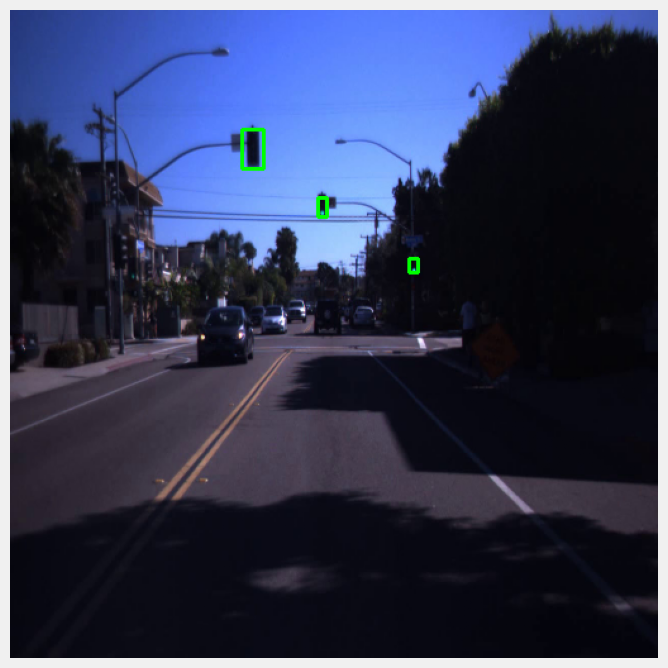

In [70]:
displayPredictions(image_ids[9],outputs[9],0.2,0.4)

## 10. Conclusion

* This could be optimized using various **Augmentation** & **Ensembling** techniques. For various Augmentations look here - [🚀](https://albumentations.ai/docs/)
* I don't know more about - **how to validate the model**. But I would be updating this notebook whenever I get to know about it. If anyone know about validating **FasterRCNN in Pytorch**, do comment below.

### 🌊 Resources:
* [Inference on Video - Notebook](https://colab.research.google.com/drive/1Zr5ozHnN9bKi6NepYVvboQ6v20i8ZO9X?usp=sharing)
* [Pytorch-Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
* [A Step-by-Step Introduction to the Basic Object Detection Algorithms](https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/)
* [Object-Detection-on-Video](https://www.dlology.com/blog/how-to-run-object-detection-and-segmentation-on-video-fast-for-free/)
* [Albumentations](https://albumentations.ai/docs/)
* [a-PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)
* [Guide to build Faster RCNN in PyTorch](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439)
* [Object Detection for Dummies Part 3: R-CNN Family](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html)